In [1]:
import os
import math
import copy
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk import word_tokenize
from collections import Counter
from torch.autograd import Variable
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.optimize import minimize

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
UNK = 0  # unknow word-id
PAD = 1  # padding word-id

from core.datasets.datasets import *
from core.datasets.sim import *
from core.models.transformer import *
from core.trains.train import *

DATABASE = './nk'
illuminant = SDS_ILLUMINANTS['D65']
cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']

mats = ['Al', 'Ag', 'Al2O3', 'AlN', 'Ge', 'HfO2', 'ITO', 'MgF2', 'MgO', 'Si', 'Si3N4', 'SiO2', 'Ta2O5', 'TiN', 'TiO2', 'ZnO', 'ZnS', 'ZnSe', 'Glass_Substrate']
thicks = [str(i) for i in range(10, 505, 10)]

lamda_low = 0.4
lamda_high = 1.1
wavelengths = np.arange(lamda_low, lamda_high+1e-3, 0.01)

nk_dict = load_materials(all_mats = mats, wavelengths = wavelengths, DATABASE = DATABASE )

def spectrum(materials, thickness, pol = 's', theta=0,  wavelengths = wavelengths, nk_dict= nk_dict, substrate = 'Glass_Substrate', substrate_thick = 500000):
    '''
    Input:
        metal materials: list  
        thickness: list
        theta: degree, the incidence angle

    Return:
        All_results: dictionary contains R, T, A, RGB, LAB
    '''
    #aa = time.time()
    degree = pi/180
    theta = theta *degree
    wavess = (1e3 * wavelengths).astype('int')
        
    thickness = [np.inf] + thickness + [substrate_thick, np.inf]

    R, T, A = [], [], []
    inc_list = ['i'] + ['c']*len(materials) + ['i', 'i']
    for i, lambda_vac in enumerate(wavess):

        n_list = [1] + [nk_dict[mat][i] for mat in materials] + [nk_dict[substrate][i], 1]

        res = inc_tmm(pol, n_list, thickness, inc_list, theta, lambda_vac)

        R.append(res['R'])
        T.append(res['T'])

    return R + T

    
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (5, 4)
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlepad'] = 10
mpl.rcParams.update({'font.size': 15})

import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/msttcorefonts/arial.ttf')
plt.rcParams['font.family'] = 'Arial'

In [2]:
# load models

a = torch.load('saved_models/optogpt/in_paper/optogpt.pt')

args = a['configs']
torch.manual_seed(args.seeds)
np.random.seed(args.seeds)
model = make_model_I(
                args.spec_dim, 
                args.struc_dim,
                args.layers, 
                args.d_model, 
                args.d_ff,
                args.head_num,
                args.dropout
            ).to(DEVICE)

model.load_state_dict(a['model_state_dict'])
loss = a['loss_all']
criterion = LabelSmoothing(args.struc_dim, padding_idx = 0, smoothing= args.smoothing)
count_params(model)

58739702

In [4]:
# load the dataset

TRAIN_FILE = './dataset/Structure_trial_0.pkl'   
TRAIN_SPEC_FILE = './dataset/Spectrum_trial_0.pkl'  
DEV_FILE = './dataset/Structure_trial_1.pkl'   
DEV_SPEC_FILE = './dataset/Spectrum_trial_1.pkl'  

data = PrepareData(TRAIN_FILE, TRAIN_SPEC_FILE, args.ratios, DEV_FILE, DEV_SPEC_FILE, args.batch_size, 'R_T', 'Inverse')

data.train_struc, data.train_spec = data.load_data(TRAIN_FILE, TRAIN_SPEC_FILE, args.ratios)
data.dev_struc, data.dev_spec = data.load_data(DEV_FILE, DEV_SPEC_FILE)
data.struc_word_dict,  data.struc_index_dict = a['configs'].struc_word_dict, a['configs'].struc_index_dict

# 03. word to id by dictionary 
data.train_struc = data.wordToID(data.train_struc, a['configs'].struc_word_dict)
data.dev_struc = data.wordToID(data.dev_struc, a['configs'].struc_word_dict)

# 04. batch + padding + mask
data.train_data = data.splitBatch(data.train_struc, data.train_spec, args.batch_size, if_inverse = 'Inverse')
data.dev_data   = data.splitBatch(data.dev_struc, data.dev_spec, args.batch_size, if_inverse = 'Inverse')

TRAIN_FILE = './dataset/Structure_trial_1.pkl'   
TRAIN_SPEC_FILE = './dataset/Spectrum_trial_1.pkl'  

data.train_struc = np.load(TRAIN_FILE, allow_pickle = True)
data.train_spec = np.load(TRAIN_SPEC_FILE, allow_pickle = True)

4.1226067543029785


Text(0.5, 1.0, 'Training curve')

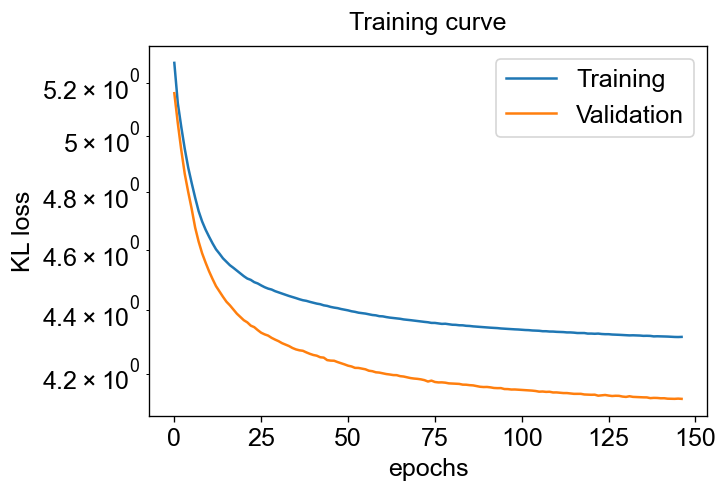

In [6]:
fig = plt.figure(dpi=120, figsize=[6, 4])
fig.patch.set_facecolor('white')

loss_train = [i.to('cpu').item() for i in a['loss_all']['train_loss']]
loss_eval = [i.to('cpu').item() for i in a['loss_all']['dev_loss']]
print(loss_eval[-1])
plt.plot(loss_train, label='Training')
plt.plot(np.array(loss_eval), label='Validation')
plt.legend()
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('KL loss')
plt.title('Training curve')

# Text generation methods

In [7]:

def return_mat_thick(struc_list):
    materials = []
    thickness = []
    for struc_ in struc_list:
        materials.append(struc_.split('_')[0])
        thickness.append(struc_.split('_')[1])

    return materials, thickness

# a finetune functoin 
from scipy.optimize import minimize
def finetune(mat_thicks, target, type='MAE'):

    materials, thickness = return_mat_thick(mat_thicks)

    M_t = len(thickness)
    x = [float(ii) for ii in thickness]
    def objective_func(x):
        R_T = spectrum(materials, list(x), wavelengths = wavelengths, nk_dict= nk_dict, substrate = 'Glass_Substrate', substrate_thick = 500000)
        if type == 'MAE':
            return np.mean(np.abs(np.array(R_T) - np.array(target) ))
        elif type == 'MSE':
            return np.sqrt(np.mean(np.square(np.array(R_T) - np.array(target) )))
        else:
            raise NotImplementedError

    bounds = [(10, 500)] * M_t

    res = minimize(objective_func, x, bounds=bounds, options={'disp':False, 'maxiter':100})
    res_x = res.x
    final_struc = [materials[i]+'_'+str(int(res_x[i])) for i in range(len(res_x))]
    return final_struc


In [ ]:
def greedy_decode(model, struc_word_dict, spec_target, max_len, start_symbol, start_mat = None):
    """
    use greedy decode to generate text 
    """
    # to do: specify the material for the model to start with. 
    # to do: specify the first material & thickness range to start with. 

    # init 1×1 tensor as prediction，fill in ('BOS')id, type: (LongTensor)
    start_symbol = struc_word_dict[start_symbol]
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.LongTensor).to(DEVICE)

    if start_mat:
        start_mat = struc_word_dict[start_mat]
        ys = torch.tensor([[start_symbol, start_mat]]).type(torch.LongTensor).to(DEVICE)
        struc_design = [start_mat]
    else:
        struc_design = []

    # process src
    src = torch.tensor([spec_target]).unsqueeze(0).float().to(DEVICE)
    src_mask = None

    struc_design = []
    probs = []
    for i in range(max_len-1):
        # decode one by one

        trg_mask = Variable(subsequent_mask(ys.size(1)).type_as(src.data))
        
        out = model(src.to(DEVICE), Variable(ys), src_mask, trg_mask.to(DEVICE))

        #  out to log_softmax 
        prob = model.generator(out[:, -1])
        probs.append(prob[0, :].to('cpu').tolist())

        #  get the max-prob id
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        #  concatnate with early predictions
        ys = torch.cat([ys,torch.ones(1, 1).type(torch.LongTensor).fill_(next_word).to(DEVICE)], dim=1)
        sym = data.struc_index_dict[next_word.to('cpu').item()]
        if sym != 'EOS':
            struc_design.append(sym)
        else:
            break

    return struc_design, probs


def top_k_n(top_k, top_p, model, struc_word_dict, spec_target, max_len, start_symbol, start_mat = None):
    # use top-k and top_n decoding methods to generate text 
    # stochastic model, random sampling based on top_k

    # determine which methods to use
    TOP_K, TOP_P, TOP_K_P = False, False, False
    if top_p < 1.0:
        if top_k == 0:
            TOP_P = True
            # print('Use methods: top-p sampling.')
        else:
            TOP_K_P = True
            # print('Use methods: top-k-p sampling.')
    elif top_p == 1:
        if top_k >0:
            TOP_K = True
            # print('Use methods: top-k sampling.')
        else:
            print('Wrong methods. Check inputs')
    else:
        raise NotImplementedError

    start_symbol = struc_word_dict[start_symbol]
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.LongTensor).to(DEVICE)

    if start_mat:
        struc_design = [start_mat]
        start_mat = struc_word_dict[start_mat]
        ys = torch.tensor([[start_symbol, start_mat]]).type(torch.LongTensor).to(DEVICE)
        
    else:
        struc_design = []

    # process src
    src = torch.tensor([spec_target]).unsqueeze(0).float().to(DEVICE)
    src_mask = None

    probs = []
    for mm in range(max_len-1):
        # decode one by one

        trg_mask = Variable(subsequent_mask(ys.size(1)).type_as(src.data))
        
        out = model(src.to(DEVICE), Variable(ys), src_mask, trg_mask.to(DEVICE))

        #  out to log_softmax 
        prob = model.generator(out[:, -1]).exp().to('cpu')

        prob_sort = torch.argsort(prob, descending=True)

        #samplingand generation
        prob_item_select = []
        if TOP_K:
            prob_item_select = prob_sort[0, :min(int(top_k), prob.size(1))].tolist()
        if TOP_P:
            prob_total = 0
            i = 0
            while prob_total < top_p:
                prob_item_select.append(prob_sort[0, i].item())
                prob_total += prob[0, prob_sort[0, i]].item()
                i += 1
        if TOP_K_P:
            prob_total = 0
            i = 0
            while prob_total < top_p and len(prob_item_select) < min(int(top_k), prob.size(1)):
                mat_design = data.struc_index_dict[prob_sort[0, i].item()].split('_')[0]
                
                # the following parts add special design constraints to the design process, you can comment this part if you don't need it. 
                
                # if data.struc_index_dict[prob_sort[0, i].item()].split('_')[0] in ['Ag', 'Al']: # constraint 
                # if mm == 2 and data.struc_index_dict[prob_sort[0, i].item()].split('_')[0] == 'Ag': # constraint 2
                # # if mm == 0 and (int(data.struc_index_dict[prob_sort[0, i].item()].split('_')[1]) > 150 or data.struc_index_dict[prob_sort[0, i].item()].split('_')[0] in ['Ag', 'Al']): # constraint 3
                # if (mm == 0 and mat_design !='Ag') or (mm == 1 and mat_design !='Si3N4') or (mm == 2 and mat_design !='Ag'): # if specify the layers 
                # # # if mm >= 0 and  data.struc_index_dict[prob_sort[0, i].item()].split('_')[0] in ['Ag', 'Al']:
                # # #     # print(int(data.struc_index_dict[prob_sort[0, i].item()].split('_')[1]))
                #     i += 1
                #     continue
                
                # if mm == 3 and prob_sort[0, i].item() == 'EOS': # useful for constraint 4
                #     prob_item_select = [i]
                #     prob_total = [prob[0, prob_sort[0, i]].item()]
                #     break
                
                # to design a perfect absorber from the science advance paper 
                # if (mm == 0 and mat_design !='MgF2') or (mm == 1 and mat_design !='SiO2') or (mm == 2 and mat_design !='Al2O3') or (mm == 3 and mat_design !='TiO2') or (mm == 4 and mat_design !='Si') or (mm == 5 and mat_design !='Ge'): # if specify the layers 
                #     i += 1
                #     continue        
                        
                # if mm == 6:
                #     if mat_design == 'EOS': # useful for constraint 4
                #         prob_item_select = [prob_sort[0, i].item()]
                #         prob_total = [1.0]
                #         break
                #     else:
                #         i += 1
                #         continue
                
                # #to design Chengang's paper
                # if (mm == 0 and mat_design !='MgF2') or (mm == 1 and mat_design !='TiO2') or (mm == 2 and mat_design !='Si') or (mm == 3 and mat_design !='Ge'): # if specify the layers 
                #     i += 1
                #     continue                
                
                # for yellow structural color 
                # # to design using only TiO2 and SiO2
                # if (mm >0 and mat_design not in ['TiO2', 'SiO2', 'EOS']) or (mm ==0 and mat_design not in ['Ge', 'TiO2', 'SiO2']): #
                #     i += 1
                #     continue    
                
                # if mat_design in ['Ag', 'Al']: #
                #     i += 1
                #     continue      
                
                # if mm == 0 and int(data.struc_index_dict[prob_sort[0, i].item()].split('_')[1]) > 200:
                #     i += 1
                #     continue                    
                # if (mm == 0 and mat_design !='TiO2') or (mm == 1 and mat_design !='MgF2') or (mm == 2 and mat_design !='ZnSe') or (mm == 3 and mat_design !='SiO2') or (mm == 4 and mat_design !='ZnSe'): # if specify the layers 
                #     i += 1
                #     continue        
                        
                # if mm == 5:
                #     if mat_design == 'EOS': # useful for constraint 4
                #         prob_item_select = [prob_sort[0, i].item()]
                #         prob_total = [1.0]
                #         break
                #     else:
                #         i += 1
                #         continue
                
                
                prob_item_select.append(prob_sort[0, i].item())
                prob_total += prob[0, prob_sort[0, i]].item()
                i += 1

        
        prob_select = [prob[0, i].item() for i in prob_item_select]
        probs.append(prob_item_select + prob_select)

        temp_sum = sum(prob_select)
        prob_select = [i/temp_sum for i in prob_select]

        next_word = np.random.choice(prob_item_select, p=prob_select)       
        
        #  concatnate with early predictions
        ys = torch.cat([ys,torch.ones(1, 1).type(torch.LongTensor).fill_(next_word).to(DEVICE)], dim=1)
        sym = data.struc_index_dict[next_word]

        if sym != 'EOS':
            struc_design.append(sym)
        else:
            break

    return struc_design, probs


In [9]:
def Gaussian_spec(center, std, peak, b = 0, if_reverse = False, wavelength = wavelengths):
    # return the spectrum based on Gaussian 
    spec = []
    for i in range(len(wavelength)):
        temp = np.round(peak*np.exp(-0.5*((center-wavelength[i])/std)**2), 3)
        temp = max(temp, b)
        if if_reverse:
            spec.append(1 - temp)
        else:
            spec.append(temp)
    return spec



In [ ]:
# method 1: design structures with spectrum that are similar to target structures 

targetsss = ['ZnO_410', 'TiO2_460', 'TiN_90', 'Si_120', 'ITO_280', 'Ge_430', 'HfO2_90', 'Al2O3_220', 'ZnSe_320', 'Al2O3_280', 'ZnO_380', 'Si_240', 'ZnO_80', 'Al2O3_50', 'ZnS_60', 'Ge_200', 'TiO2_280', 'ITO_480', 'AlN_320', 'ZnO_170']

# good: 34, 1000, 8999
# good for trial_I_6: 
temp = 100

# temp = 10654 # absorber examples using the same reflection spectrum 
# targetsss = [data.struc_index_dict[int(w)] for w in data.dev_struc[temp][1:-1]]
# targetsss = [data.struc_index_dict[int(w)] for w in data.dev_struc[temp]

# temp = 10840 # absorber examples using reflection = Reflection + transmission, temp = 738
# temp_spec = data.dev_spec[temp]
# spec_target = [temp_spec[i] + temp_spec[i+71] for i in range(71)] + [0] * 71


material, thickness =  return_mat_thick(targetsss)
# material, thickness = material[0], thickness[0]
# material, thickness =  ['Si3N4', 'ZnSe', 'Si', 'ZnSe', 'Si3N4'], [110, 20, 25, 20, 110]
# material, thickness = ['Al2O3', 'Ta2O5'], [140, 190] # good
# material, thickness =  ['Al2O3', 'Ta2O5'], [70, 190]
material, thickness = ['Ag', 'SiO2', 'Ag'], [20, 150, 50] 
# material, thickness = [ 'SiO2', 'TiO2'] * 10,  [100, 80] * 10 # also good for DBR. 
# material, thickness = [ 'SiO2', 'TiO2'] * 20,  [100, 80] * 20 # also good for DBR. 
# material, thickness = [ 'SiO2', 'TiO2'] * 4,  [100, 80] * 4


print('Target structure:', [material[j]+'_'+str(thickness[j]) for j in range(len(thickness)) ])
spec_target = spectrum(material, thickness, wavelengths = wavelengths, nk_dict= nk_dict, substrate = 'Glass_Substrate', substrate_thick = 500000)


# method 2: design structures with spectrum close to artificial spectrum

# spec_target = Gaussian_spec(0.7, 0.03, 0.8) + [0]*71
# spec_target = Gaussian_spec(0.55, 0.05, 1) + [0]*71
# spec_target = Gaussian_spec(0.7, 0.03, 1, if_reverse = True) + Gaussian_spec(0.7, 0.03, 1)
# spec_target = Gaussian_spec(0.5, 0.05, 1, if_reverse = True) + Gaussian_spec(0.5, 0.05, 1)
# spec_target = Gaussian_spec(0.5, 0.04, 0.8, b=0.1) + Gaussian_spec(0.5, 0.04, 0.8, b=0.1) # same color for R and T
# spec_target = Gaussian_spec(0.5, 0.04, 0.5, b=0.0) + Gaussian_spec(0.5, 0.04, 0.5, b=0.0) # same color for R and T

# spec_target = [0]*142 # perfect absorber
# spec_target = [0.1]*71 + [0] * 71 # piano black 
# spec_target = [0]*71 + [1] * 71 # reduce reflection
# spec_target = [1]*71 + [0]*71 # ultra broadband reflector 
spec_target = [0]*38 + [1] *33 + [1]*38 + [0]*33 # high reflection in NIR # show in paper 
# spec_target = [0]*30 + [1] *41 + [1]*30 + [0]*41 # high reflection in NIR # show in paper 
# spec_target = [0]*40 + [0] *10 + [0]*21 + [0]*30 + [1] *10 + [0]*31 # bandpass at 700nm, bad
# spec_target = [1]*30 + [0] *10 + [1]*31 + [0]*30 + [1] *10 + [0]*31 # bandpass at 700nm, bad
# spec_target = [0]*20 + [1]*25+[0]*10+[1]*16 + [1]*20 + [0]*25+[1]*10+[0]*16 # bandpass at 900nm, somehow good
# spec_target = Gaussian_spec(0.9, 0.05, 1, if_reverse = True) + Gaussian_spec(0.9, 0.05, 1)
# spec_target = [0]*25 + [1] *10 + [0]*36 + [1]*25 + [0] *10 + [1]*36 # filter in 650-750nm # 
# spec_target = [0]*10 + [1] *10 + [0]*51 + [1]*10 + [0] *10 + [1]*51 # filter in 550nm 
# spec_target = [0]*13 + [1] *6 + [0]*52 + [1]*13 + [0] *6 + [1]*52 # filter in 550nm, 60nm bandwidth, shown in paper
# spec_target = [0]*47 + [1] *6 + [0]*18 + [1]*47 + [0] *6 + [1]*18 # filter in 900nm , shown in SI
# spec_target = [0]*27 + [1] *6 + [0]*38 + [1]*27 + [0] *6 + [1]*38 # high reflection in 670-730nm #  shown in paper 
# spec_target = [0]*28 + [1] *4 + [0]*39 + [1]*28 + [0] *4 + [1]*39 # high reflection in 680-720nm #
# spec_target = [0]*20 + [1] *30 + [0]*21 + [1]*20 + [0] *30 + [1]*21 # high reflection in 600-900nm # shown in SI
# spec_target = [0]*10 + [1] *10 + [0]*20 + [1]*20 + [0] *11 + [1]*10 + [0] *10 + [1]*20 + [0]*20 + [1] *11  # high reflection in 500-600, and 800-1000 nm, shown in paper


model.eval()
with torch.no_grad():
    struc_design_g, probs_g = greedy_decode(model, data.struc_word_dict, spec_target, max_len=args.max_len, start_symbol="BOS")
    material_design_g, thickness_design_g =  return_mat_thick(struc_design_g)
    spec_design_g = spectrum(material_design_g, thickness_design_g, wavelengths = wavelengths, nk_dict= nk_dict, substrate = 'Glass_Substrate', substrate_thick = 500000)
    print('Greedy structure:', struc_design_g)

    struc_design_k_p, probs_k_p, spec_design_k_p = [], [], []
    print('Top kp sampling:')
    for kk in range(20): # we can run the algorithm multiple times to get the best structure
        
        # The following code lists some good structures that our model designed for specific applications. 
        
        # struc_design_k, probs_k = top_k_n(10, 0.9, model, data.struc_word_dict, spec_target, max_len=args.max_len, start_symbol="BOS")
        a = time.time()
        struc_design_k, probs_k = top_k_n(10, 0.8, model, data.struc_word_dict, spec_target, max_len=args.max_len, start_symbol="BOS")
        # struc_design_k, probs_k = top_k_n(10, 0.8, model, data.struc_word_dict, spec_target, max_len=args.max_len, start_symbol="BOS")

        # struc_design_k = ['MgF2_100', 'AlN_70', 'ZnS_440', 'Si_480', 'Ge_230', 'ZnS_480', 'ZnSe_320', 'ITO_500', 'MgF2_330', 'Ag_40'] # for the perfect absorber
        # struc_design_k = ['MgF2_400', 'Si3N4_210', 'MgF2_300', 'HfO2_190', 'SiO2_280', 'Ta2O5_200', 'MgF2_300', 'HfO2_200', 'MgF2_320', 'ZnO_210', 'MgF2_290', 'MgO_500'] # for band-notch in 550nm, 60nm bandwidth
        # struc_design_k = ['SiO2_490', 'Al2O3_220', 'Ta2O5_230', 'SiO2_360', 'Ta2O5_250', 'Al2O3_310', 'Ta2O5_270', 'Al2O3_310', 'Ta2O5_430', 'MgO_280', 'HfO2_410'] # band notch at 700 nm
        # struc_design_k = ['Al2O3_70', 'HfO2_110', 'AlN_460', 'MgO_350', 'Ta2O5_140', 'MgO_390', 'AlN_460', 'Ta2O5_330', 'Al2O3_460', 'HfO2_500', 'MgO_410', 'Ta2O5_120', 'MgO_350', 'Ta2O5_340', 'SiO2_190', 'MgO_480', 'Ta2O5_130', 'MgF2_480'] 
        # band notch at 900nm, in SI.
        # struc_design_k = ['Al2O3_480', 'MgO_480', 'Ta2O5_120', 'MgF2_180', 'Ta2O5_120', 'MgF2_170', 'Ta2O5_120', 'MgF2_180', 'Ta2O5_110', 'SiO2_180', 'Ta2O5_130']  # NIR high reflection 
        # struc_design_k = ['Al2O3_420', 'MgF2_400', 'Ta2O5_110', 'SiO2_170', 'Ta2O5_100', 'MgF2_170', 'TiO2_110', 'MgF2_200', 'Ta2O5_100', 'MgF2_170', 'Ta2O5_130', 'MgF2_430'] # another NIR high reflection 
        # struc_design_k = ['MgF2_250', 'TiO2_90', 'MgF2_140', 'HfO2_80', 'MgF2_130', 'TiO2_90', 'MgF2_140', 'Ta2O5_490', 'MgF2_170', 'HfO2_500']  # for high reflection in 600-900 nm
        # struc_design_k = ['Al2O3_330', 'Ta2O5_70', 'MgF2_490', 'TiO2_60', 'Al2O3_250', 'Ta2O5_60', 'MgF2_490', 'HfO2_320', 'MgF2_470', 'Ta2O5_90', 'SiO2_460', 'HfO2_310', 'MgF2_490'] # for double high reflection in 500-600, 800-1000nm
        # struc_design_k = ['MgF2_200', 'Ta2O5_190', 'MgF2_310', 'TiO2_170', 'MgF2_310', 'Ta2O5_190'] # for high reflection in 550nm
        # struc_design_k =  ['ITO_60', 'MgF2_240', 'Ag_30', 'SiO2_160', 'Ag_40']
        # struc_design_k = ['Ag_30', 'AlN_110', 'Ag_40']
        
        # for FP cavity
        # if kk == 0:
        #     struc_design_k =  ['SiO2_100', 'Ag_30', 'AlN_110', 'Ag_50']
        # if kk == 1:
        #     struc_design_k = ['Ag_30', 'Al2O3_150', 'Al_30', 'MgF2_400']
        # if kk == 2:
        #     struc_design_k = ['Si3N4_60', 'Ag_40', 'Al2O3_140', 'Ag_50']
        # if kk == 3:
        #     struc_design_k = ['Ag_30', 'Si3N4_100', 'Ag_40']
        
        # struc_design_k =  ['Ag_30', 'Si3N4_100', 'Ag_40']
        
        
        # #for absorber
        # if kk == 0:
        #     struc_design_k = ['MgF2_100', 'AlN_70', 'ZnS_440', 'Si_480', 'Ge_230', 'ZnS_480', 'ZnSe_320', 'ITO_500', 'MgF2_330', 'Ag_40'] # in paper
        # if kk == 1:
        #     struc_design_k = ['MgF2_100', 'SiO2_10', 'Al2O3_90', 'TiO2_50', 'Si_490', 'Ge_420', 'TiN_410'] # fpr advanced science paper
        # if kk == 2:
        #     struc_design_k = ['MgF2_90', 'TiO2_50', 'Si_480', 'Ge_380', 'TiN_340'] # for chengang's paper
        
        b = time.time()
        # print('Design time:', b-a, 's.')
        material_design_k, thickness_design_k =  return_mat_thick(struc_design_k)
        spec_design_k = spectrum(material_design_k, thickness_design_k, wavelengths = wavelengths, nk_dict= nk_dict, substrate = 'Glass_Substrate', substrate_thick = 500000)
        struc_design_k_p.append(struc_design_k)
        probs_k_p.append(probs_k)
        spec_design_k_p.append(spec_design_k)
        print('Structure '+str(kk)+': MAE= ', np.mean(np.abs(np.array(spec_design_k) - np.array(spec_target))),struc_design_k)
    
    spec_design_k_p = np.array(spec_design_k_p)



Target structure: ['Ag_20', 'SiO2_150', 'Ag_50']
Greedy structure: ['Al2O3_500', 'TiN_10', 'Al2O3_90', 'TiO2_90', 'MgF2_180', 'Ta2O5_120']
Top kp sampling:
Structure 0: MAE=  0.280109736853 ['Al2O3_330', 'Ta2O5_110', 'Al2O3_340', 'Si3N4_120', 'MgF2_190', 'TiO2_110', 'MgF2_190', 'Ta2O5_290', 'SiO2_170', 'HfO2_130', 'MgF2_180', 'Ta2O5_290', 'MgF2_220', 'Ta2O5_110']
Structure 1: MAE=  0.203125254497 ['Al2O3_430', 'MgF2_180', 'Ta2O5_110', 'MgF2_190', 'Ta2O5_110', 'SiO2_180', 'Ta2O5_110', 'MgF2_190', 'Ta2O5_110', 'Al2O3_360', 'HfO2_490']
Structure 2: MAE=  0.204115479427 ['SiO2_340', 'Ta2O5_110', 'MgF2_180', 'TiO2_100', 'MgF2_180', 'Ta2O5_120', 'SiO2_380', 'MgO_230', 'Ta2O5_480', 'MgF2_190', 'Ta2O5_120', 'MgF2_170']
Structure 3: MAE=  0.204024146102 ['Al2O3_500', 'MgO_470', 'TiO2_100', 'Al2O3_170', 'Ta2O5_110', 'MgF2_200', 'Ta2O5_120', 'SiO2_170', 'HfO2_120', 'MgF2_190', 'HfO2_130', 'MgF2_150', 'Ta2O5_290', 'SiO2_200', 'HfO2_100', 'MgF2_210']
Structure 4: MAE=  0.213857524374 ['Al2O3_430', 

In [11]:
temp_close = np.argmin(np.mean(np.abs(data.train_spec - np.array(spec_target)), axis = 1))
# temp_close = np.argmin(np.mean(np.square(data.train_spec - np.array(spec_target)), axis = 1)) # use this when the target is sharp

struc_train = data.train_struc[temp_close]

In [12]:
# finetune structures 

struc_trgs_ = [material[j]+'_'+str(thickness[j]) for j in range(len(thickness)) ]
temp_close_kp = np.argmin(np.mean(np.square(spec_design_k_p - np.array(spec_target)), axis = 1))
temp_struc_close_kp = struc_design_k_p[temp_close_kp]

temp_struc_close_kp_ft = finetune(temp_struc_close_kp, np.array(spec_target), type='MAE')
mat_temp, thick_temp = return_mat_thick(temp_struc_close_kp_ft)
spec_design_k_p_ft = spectrum(mat_temp, thick_temp)
spec_design_k_p_ft = np.array(spec_design_k_p_ft)

print(temp_close_kp)
print('Original Struc:', struc_trgs_)
print('Best  in  data:', struc_train)
print('Designed Struc:', temp_struc_close_kp)
print('Designed Ftune:', temp_struc_close_kp_ft)


temp_spec = spec_design_k_p
temp_mean = np.mean(np.abs(temp_spec - spec_target), axis = 1)
temp_struc = struc_design_k_p
for i in range(20):
    print(temp_mean[i], temp_struc[i])

2
Original Struc: ['Ag_20', 'SiO2_150', 'Ag_50']
Best  in  data: ['Si3N4_120', 'SiO2_160', 'AlN_120']
Designed Struc: ['SiO2_340', 'Ta2O5_110', 'MgF2_180', 'TiO2_100', 'MgF2_180', 'Ta2O5_120', 'SiO2_380', 'MgO_230', 'Ta2O5_480', 'MgF2_190', 'Ta2O5_120', 'MgF2_170']
Designed Ftune: ['SiO2_293', 'Ta2O5_113', 'MgF2_176', 'TiO2_104', 'MgF2_178', 'Ta2O5_115', 'SiO2_380', 'MgO_226', 'Ta2O5_445', 'MgF2_189', 'Ta2O5_120', 'MgF2_188']
0.280109736853 ['Al2O3_330', 'Ta2O5_110', 'Al2O3_340', 'Si3N4_120', 'MgF2_190', 'TiO2_110', 'MgF2_190', 'Ta2O5_290', 'SiO2_170', 'HfO2_130', 'MgF2_180', 'Ta2O5_290', 'MgF2_220', 'Ta2O5_110']
0.203125254497 ['Al2O3_430', 'MgF2_180', 'Ta2O5_110', 'MgF2_190', 'Ta2O5_110', 'SiO2_180', 'Ta2O5_110', 'MgF2_190', 'Ta2O5_110', 'Al2O3_360', 'HfO2_490']
0.204115479427 ['SiO2_340', 'Ta2O5_110', 'MgF2_180', 'TiO2_100', 'MgF2_180', 'Ta2O5_120', 'SiO2_380', 'MgO_230', 'Ta2O5_480', 'MgF2_190', 'Ta2O5_120', 'MgF2_170']
0.204024146102 ['Al2O3_500', 'MgO_470', 'TiO2_100', 'Al2O3_170

MAE (best in data) =0.3646
 MAE (Top kp design) =0.2041
 MAE (Finetuned) =0.185


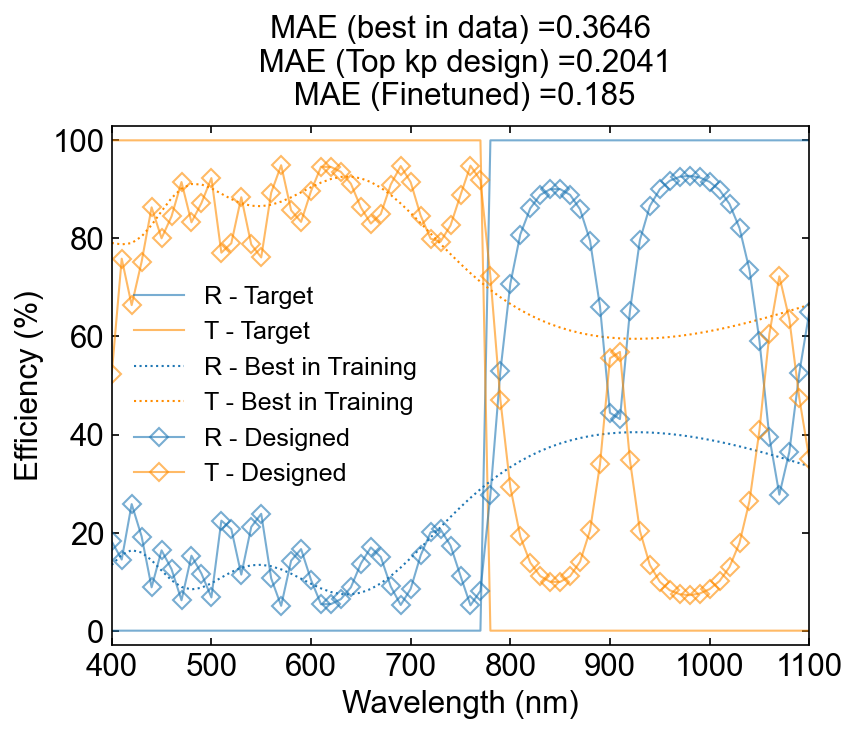

In [13]:
fig = plt.figure(dpi=150, figsize=[6, 4.5])

fig.patch.set_facecolor('white')
ax = plt.subplot(111)

plt.plot(wavelengths*1000, np.array(spec_target[:71])*100, color='tab:blue', alpha=0.6, linewidth = 1, label='R - Target')
plt.plot(wavelengths*1000, np.array(spec_target[ 71:])*100,color='darkorange',alpha=0.6, linewidth = 1, label='T - Target')

plt.plot(wavelengths*1000, data.train_spec[temp_close, :71]*100, ':', fillstyle = 'none', linewidth = 1, color='tab:blue', label='R - Best in Training')
plt.plot(wavelengths*1000, data.train_spec[temp_close, 71:]*100, ':', fillstyle = 'none', linewidth = 1, color='darkorange', label='T - Best in Training')


plt.plot(wavelengths*1000, spec_design_k_p[temp_close_kp, :71]*100, 'D-',  fillstyle = 'none', alpha=0.6, color='tab:blue',linewidth = 1,  label='R - Designed')
plt.plot(wavelengths*1000, spec_design_k_p[temp_close_kp, 71:]*100, 'D-',  fillstyle = 'none', alpha = 0.6, color='darkorange', linewidth = 1, label='T - Designed')

# # plt.plot(wavelengths, spec_design_g[:71], '*--', fillstyle = 'none', color='tab:blue', label='R - Greedy Design')
# # plt.plot(wavelengths, spec_design_g[71:], '*--', fillstyle = 'none', color='tab:red', label='T - Greedy Design')

spec_design_k_p_ft = np.array(spec_design_k_p_ft)

# plt.plot(wavelengths*1000, spec_design_k_p_ft[:71]*100, '<-', fillstyle = 'none', alpha=0.6, color='tab:blue',linewidth = 1,  label='R - Finetuned')
# plt.plot(wavelengths*1000, spec_design_k_p_ft[71:]*100, '<-', fillstyle = 'none', alpha = 0.6, color='darkorange', linewidth = 1, label='T - Finetuned')

# For absorber applications
spec_design_k_p_a = 1 - (spec_design_k_p[:, :71] + spec_design_k_p[:, 71:])

# plt.plot(wavelengths*1000, 100-np.array(spec_target[ :71])*100-np.array(spec_target[ 71:])*100, color='tab:red',alpha=0.6, label='A - Target')
# plt.plot(wavelengths*1000, 100 - data.train_spec[temp_close, 71:]*100-data.train_spec[temp_close, :71]*100, ':', fillstyle = 'none', linewidth = 1, color='tab:red', label='A - Closest')
# plt.plot(wavelengths*1000, 100-spec_design_k_p[temp_close_kp, 71:]*100-spec_design_k_p[temp_close_kp, :71]*100, 'D-', fillstyle = 'none', alpha = 0.6, color='tab:red', linewidth = 1, label='A - Designed')
# plt.plot(wavelengths*1000, 100-spec_design_k_p_ft[71:]*100-spec_design_k_p_ft[:71]*100, '<-', fillstyle = 'none', alpha = 0.6, color='darkorange', linewidth = 1, label='A - Finetuned')





plt.ylim(-3, 103)
plt.legend(loc = 'center left', fontsize = 12, frameon=False)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Efficiency (%)')
mae_g = round(np.mean(np.abs(np.array(spec_target) - np.array(spec_design_g))), 4)
mae_kp = round(np.mean(np.abs(np.array(spec_target) - spec_design_k_p[temp_close_kp, :])), 4)
mae_kp_ft = round(np.mean(np.abs(np.array(spec_target) - spec_design_k_p_ft)), 4)
mae_d = round(np.mean(np.abs(data.train_spec[temp_close, :] - np.array(spec_target))), 4)
mse_g = round(np.sqrt(np.mean(np.abs(np.array(spec_target) - np.array(spec_design_g)))), 4)
mse_kp = round(np.sqrt(np.mean(np.abs(np.array(spec_target) - spec_design_k_p[temp_close_kp, :]))), 4)
mse_d = round(np.sqrt(np.mean(np.abs(data.train_spec[temp_close, :] - np.array(spec_target)))), 4)

titless = 'MAE (best in data) ='+str(mae_d) +  '\n ' + 'MAE (Top kp design) ='+str(mae_kp) +'\n ' + 'MAE (Finetuned) ='+str(mae_kp_ft) 
print(titless)
# titless = 'RMSE (best in data) ='+str(mse_d) + '\n ' + 'RMSE (Top kp design) ='+str(mse_kp) 
plt.title(titless)

plt.xlim(400, 1100)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')


# Design structural color

In [8]:
import numpy as np
import glob
from scipy.optimize import minimize
# from color_system import cs_srgb
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import colour
# from tqdm.notebook import tqdm, tnrange
from multiprocessing import Pool
import time
import os
import networkx
import warnings
import colour
from colour.difference import delta_E, delta_E_CIE2000
from colour import SDS_ILLUMINANTS, SpectralDistribution
from colour.colorimetry import MSDS_CMFS
illuminant = SDS_ILLUMINANTS['D65']
cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']


warnings.filterwarnings("ignore")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00727766085665
            Iterations: 39
            Function evaluations: 2852
            Gradient evaluations: 39
[ 0.9113003  -0.03749957  0.47881792] [  4.99999855e+01   8.00001008e+01   4.64695107e-06] [50, 80, 0] 2.6339312614e-05 0.55666064858 0.00813173889778


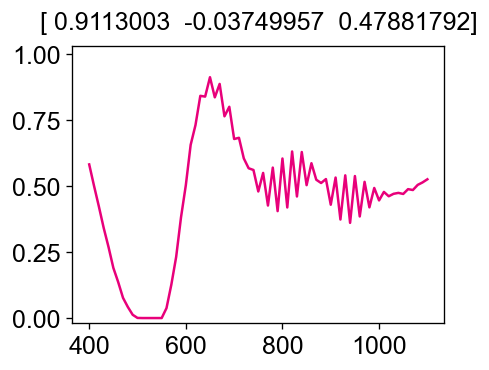

In [145]:
# optimize to get the spectrum from RGB color 

# for reflective colro 

# good color: [0,4, 1, 0]
# good LAB color:  [60, 0, 80], seed: 201, designed: ['MgO_40', 'ITO_220', 'TiN_310', 'Ag_70']
# good LAB color: [50, 80, 0], seed: 2, alpha=200, designed: ['ZnSe_100', 'MgF2_60', 'ZnSe_120', 'TiN_280', 'ZnO_320', 'MgO_490'] pink 
# good LAB color: [70, 0, -80], seed: 2, designed: ['ZnO_70', 'Al_10', 'HfO2_90', 'Ag_380', 'Si3N4_280']  blue 
# good LAB color: [70, -80, 0], seed: 2, designed: ['TiO2_160', 'MgF2_80', 'HfO2_180', 'SiO2_120', 'AlN_190']  green 
# good LAB color: [50, 30, 80], seed: 2, alpha=200, ['AlN_40', 'Si_70', 'TiN_280', 'MgF2_430', 'AlN_420', 'Si3N4_350', 'MgF2_270', 'Si3N4_410', 'SiO2_400'] gold
# good LAB color: [70, 40, 80], seed: 2, alpha=200, ['Ta2O5_140', 'TiN_40', 'ZnSe_100', 'Ag_490', 'MgF2_140', 'Ag_50', 'Si3N4_420'] orange

# for transmissive color 
# good LAB color: [40, 30, 30], seed: 2, designed: ['ZnS_40', 'MgF2_100', 'ZnSe_40', 'MgF2_90', 'ZnSe_50', 'MgF2_70', 'Ta2O5_60', 'MgF2_60', 'Al2O3_150']  # brown 
# good LAB color: [40, -80, 0], seed: 100, designed: ['Ta2O5_270', 'Ag_40', 'MgF2_160', 'TiO2_200', 'ITO_70'], with min 0.05 # green
# good LAB color: [80, 0, 80], seed: 100, alpha=500, designed: ['ZnO_60', 'MgF2_70', 'TiO2_40', 'MgF2_250', 'ZnSe_240']， with min 0.05  # yellow 


TARGET = [0,  0.6, 0.6] # this is RGB target
TARGET_LAB = colour.sRGB_to_XYZ(TARGET) * 100
TARGET_LAB = [70, 40, 80]
TARGET_LAB = [50, 80, 0]


wavelengthss = np.arange(400, 1101, 10)

def get_rgb_from_spec(spec):
    wavelengthss = np.arange(400, 801, 10)
    data = dict(zip(wavelengthss, spec[:41]))
    sd = colour.SpectralDistribution(data, name='Sample')
    rgb = colour.convert(sd, 'Spectral Distribution', 'sRGB')
    return rgb

def get_color(spec):
    # return the xyY, RGB, LAB from spectrum
    wavelengthss = np.arange(400, 801, 10)
    data = dict(zip((wavelengthss).astype('int'), spec[:41]))
    sd = SpectralDistribution(data)
    XYZ = colour.sd_to_XYZ(sd, cmfs, illuminant)
    xyY = colour.XYZ_to_xyY(XYZ)
    Lab = colour.XYZ_to_Lab(XYZ / 100)
    RGB = colour.XYZ_to_sRGB(XYZ / 100)
    return Lab, RGB, xyY

def fitness(spec, MODE = 'DeltaE'):
    lab, rgb, xyy = get_color(spec)
    if MODE == 'DeltaE':
        mse = delta_E_CIE2000(lab, TARGET_LAB)
        smoothness = np.square(np.gradient(np.gradient(spec))).mean()
        return mse + 50*smoothness
    elif MODE == 'RGB':
        mse = np.mean(np.square(TARGET - rgb))
        smoothness = np.square(np.gradient(np.gradient(spec))).mean()
        return mse + 10*smoothness
    else:
        raise NotImplementedError

# retrive the spectrum from the LAB values

np.random.seed(100)
x0 = np.random.rand((1100-400) // 10 + 1)
# x0[31:] = 0
bounds = [[0, 1] for _ in range(len(x0))]

res = minimize(fitness, x0, method='SLSQP', options={'disp': True, 'maxiter':100, 'tol':1e-9}, bounds=bounds)
spec_rgb = list(res.x)

lab2, rgb2, xyy2 = get_color(res.x)
mse = np.mean(np.abs(TARGET - rgb2))
deltae = delta_E_CIE2000(lab2, TARGET_LAB)
smoothness = np.abs(np.gradient(np.gradient(res.x))).mean()
print(rgb2, lab2, TARGET_LAB, deltae, mse, smoothness)

# plot the retrived spectrum
fig = plt.figure(dpi=120, figsize=[4, 3])
fig.patch.set_facecolor('white')
plt.plot(wavelengthss, res.x, color = np.clip(rgb2, 0, 1))
plt.title(rgb2)
plt.ylim(-0.020, 1.03)
plt.show()

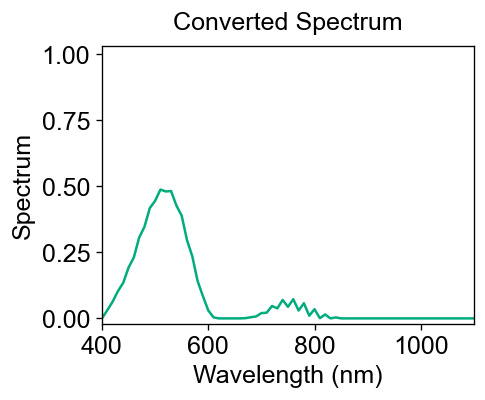

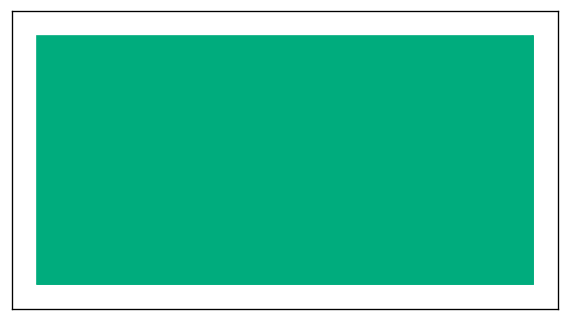

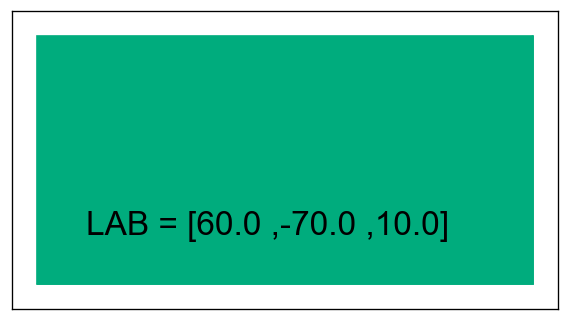

In [106]:
fig = plt.figure(dpi=120, figsize=[4, 3])
fig.patch.set_facecolor('white')
plt.plot(wavelengthss, res.x, color = np.clip(rgb2, 0, 1))
plt.title(rgb2)
plt.ylim(-0.020, 1.03)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectrum')
plt.title('Converted Spectrum')
plt.xlim(400, 1100)
plt.show()

colors_R = []
colors_R.append(colour.plotting.ColourSwatch(RGB=rgb2))

fig, ax = colour.plotting.plot_multi_colour_swatches(colors_R, spacing=0.1, columns=1, width=2, height=1)
fig.patch.set_facecolor('white')

ax.text( 0.2, 0.2, 'LAB = ['+str(round(lab2[0], 1))+' ,'+str(round(lab2[1], 1))+' ,'+str(round(lab2[2], 1))+']', fontsize = 20)
# ax.text( 0, 0.2, 'LAB = \n['+str(round(TARGET_LAB[0], 1))+','+str(int(TARGET_LAB[1]))+','+str(round(TARGET_LAB[2], 1))+']', fontsize = 40)

fig

In [146]:
spec_target = spec_rgb + [0]*71 #  for reflective color
# spec_target = [1-ii for ii in spec_rgb] + spec_rgb  #  for transmissive color 

model.eval()
with torch.no_grad():
    struc_design_g, probs_g = greedy_decode(model, data.struc_word_dict, spec_target, max_len=args.max_len, start_symbol="BOS")
    material_design_g, thickness_design_g =  return_mat_thick(struc_design_g)
    spec_design_g = spectrum(material_design_g, thickness_design_g, wavelengths = wavelengths, nk_dict= nk_dict, substrate = 'Glass_Substrate', substrate_thick = 500000)
    print('Greedy structure:', struc_design_g)

    struc_design_k_p, probs_k_p, spec_design_k_p = [], [], []
    print('Top kp sampling:')
    spec_design_k_p_deltaE = []
    spec_design_k_p_rgb = []
    for kk in range(20):
        struc_design_k, probs_k = top_k_n(10, 0.8, model, data.struc_word_dict, spec_target, max_len=args.max_len, start_symbol="BOS")
        # struc_design_k, probs_k = top_k_n(15, 0.9, model, data.struc_word_dict, spec_target, max_len=args.max_len, start_symbol="BOS", start_mat='MgF2_100')
        
        # struc_design_k = ['ZnS_40', 'MgF2_100', 'ZnSe_40', 'MgF2_90', 'ZnSe_50', 'MgF2_70', 'Ta2O5_60', 'MgF2_60', 'Al2O3_150'] # brown color in the paper
        # struc_design_k = ['Ta2O5_270', 'Ag_40', 'MgF2_160', 'TiO2_200', 'ITO_70'] / ['Ag_30', 'Ta2O5_70', 'Ag_30', 'TiO2_240']  # for green color 
        struc_design_k = ['ZnO_60', 'MgF2_70', 'TiO2_40', 'MgF2_250', 'ZnSe_240']  # for yellow color 
        struc_design_k = ['ZnO_70', 'Al_10', 'HfO2_90', 'Ag_380', 'Si3N4_280']  # for blue , reflective
        struc_design_k =  ['Ta2O5_140', 'TiN_40', 'ZnSe_100', 'Ag_490', 'MgF2_140', 'Ag_50', 'Si3N4_420']  # for orange, reflective
        struc_design_k =  ['ZnSe_100', 'MgF2_60', 'ZnSe_120', 'TiN_280', 'ZnO_320', 'MgO_490']
        material_design_k, thickness_design_k =  return_mat_thick(struc_design_k)
        spec_design_k = spectrum(material_design_k, thickness_design_k, wavelengths = wavelengths, nk_dict= nk_dict, substrate = 'Glass_Substrate', substrate_thick = 500000)
        struc_design_k_p.append(struc_design_k)
        probs_k_p.append(probs_k)
        spec_design_k_p.append(spec_design_k)
        lab_kp, rgb_kp, xyy_kp = get_color(spec_design_k)
        # lab_kp, rgb_kp, xyy_kp = get_color(spec_design_k[71:])  # for transmissive 
        spec_design_k_p_rgb.append(rgb_kp)
        spec_design_k_p_deltaE.append(delta_E_CIE2000(lab2, lab_kp))
        if delta_E_CIE2000(lab2, lab_kp) <5:
            print('Structure '+str(kk)+': DeltaE = ', delta_E_CIE2000(lab2, lab_kp), struc_design_k)
    
    spec_design_k_p = np.array(spec_design_k_p)


# Brown: 
# Designed Struc: ['ZnSe_40', 'MgF2_90', 'ZnSe_50', 'MgF2_100', 'ZnSe_40', 'MgF2_70', 'Ta2O5_160']  # delta E = 3.3
# Designed Ftune: ['ZnSe_35', 'MgF2_90', 'ZnSe_54', 'MgF2_102', 'ZnSe_39', 'MgF2_69', 'Ta2O5_162']

# Green: [60, -70, 10]
# Designed Struc: ['Ag_30', 'Ta2O5_70', 'Ag_30', 'TiO2_240']
# Designed Ftune: ['Ag_26', 'Ta2O5_68', 'Ag_28', 'TiO2_240']


Greedy structure: ['Ta2O5_160', 'Ge_40', 'MgF2_350', 'ZnO_150', 'Al_20']
Top kp sampling:
Structure 0: DeltaE =  3.13593201304 ['ZnSe_100', 'MgF2_60', 'ZnSe_120', 'TiN_280', 'ZnO_320', 'MgO_490']
Structure 1: DeltaE =  3.13593201304 ['ZnSe_100', 'MgF2_60', 'ZnSe_120', 'TiN_280', 'ZnO_320', 'MgO_490']
Structure 2: DeltaE =  3.13593201304 ['ZnSe_100', 'MgF2_60', 'ZnSe_120', 'TiN_280', 'ZnO_320', 'MgO_490']
Structure 3: DeltaE =  3.13593201304 ['ZnSe_100', 'MgF2_60', 'ZnSe_120', 'TiN_280', 'ZnO_320', 'MgO_490']
Structure 4: DeltaE =  3.13593201304 ['ZnSe_100', 'MgF2_60', 'ZnSe_120', 'TiN_280', 'ZnO_320', 'MgO_490']
Structure 5: DeltaE =  3.13593201304 ['ZnSe_100', 'MgF2_60', 'ZnSe_120', 'TiN_280', 'ZnO_320', 'MgO_490']
Structure 6: DeltaE =  3.13593201304 ['ZnSe_100', 'MgF2_60', 'ZnSe_120', 'TiN_280', 'ZnO_320', 'MgO_490']
Structure 7: DeltaE =  3.13593201304 ['ZnSe_100', 'MgF2_60', 'ZnSe_120', 'TiN_280', 'ZnO_320', 'MgO_490']
Structure 8: DeltaE =  3.13593201304 ['ZnSe_100', 'MgF2_60', '

In [27]:
temp_close = np.argmin(np.mean(np.abs(data.train_spec - np.array(spec_target)), axis = 1))
# temp_close = np.argmin(np.mean(np.abs(data.train_spec[:, 71:] - np.array(spec_target)[71:]), axis = 1)) # for transmissibe

# temp_close = np.argmin(np.mean(np.square(data.train_spec - np.array(spec_target)), axis = 1)) 

struc_train = data.train_struc[temp_close]


In [132]:
def finetune_rgb(mat_thicks, target, type='DeltaE'):

    materials, thickness = return_mat_thick(mat_thicks)

    M_t = len(thickness)
    x = [float(ii) for ii in thickness]
    def objective_func(x):
        R_T = spectrum(materials, list(x), wavelengths = wavelengths, nk_dict= nk_dict, substrate = 'Glass_Substrate', substrate_thick = 500000)
        # labs, rgbs, xyys = get_color(R_T)  # for reflective color
        labs, rgbs, xyys = get_color(R_T[71:]) # for transmissive color 
        if type == 'DeltaE':
            return delta_E_CIE2000(labs, target)
        elif type == 'MAE':
            return np.mean(np.abs(np.array(rgbs) - np.array(target) ))
        elif type == 'MSE':
            return np.sqrt(np.mean(np.square(np.array(rgbs) - np.array(target) )))
        else:
            raise NotImplementedError

    bounds = [(10, 500)] * M_t

    res = minimize(objective_func, x, bounds=bounds, options={'disp':False, 'maxiter':100})
    res_x = res.x
    print(res.fun)
    final_struc = [materials[i]+'_'+str(int(res_x[i])) for i in range(len(res_x))]
    return final_struc

In [133]:
# ['ZnSe_40', 'MgF2_70', 'HfO2_40', 'MgF2_90', 'ZnSe_60', 'MgF2_250', 'TiO2_60', 'Al2O3_50']
# ['TiO2_30', 'SiO2_80', 'TiO2_70', 'SiO2_50', 'TiO2_50', 'SiO2_90', 'TiO2_50', 'SiO2_70', 'TiO2_10', 'SiO2_260', 'TiO2_150', 'SiO2_100', 'TiO2_60', 'SiO2_230', 'TiO2_80', 'SiO2_60', 'TiO2_140', 'SiO2_250', 'SiO2_350', 'SiO2_60', 'TiO2_400‘]

# spec_design_k_p_deltaE = [delta_E_CIE2000(lab2, get_color(specc)[0]) for specc in spec_design_k_p] # for reflective  
spec_design_k_p_deltaE = [delta_E_CIE2000(lab2, get_color(specc[71:])[0]) for specc in spec_design_k_p] # for transmissive


temp_close_kp = np.argmin(spec_design_k_p_deltaE)

temp_struc_close_kp = struc_design_k_p[temp_close_kp]

temp_struc_close_kp_ft = finetune_rgb(temp_struc_close_kp, lab2, type='DeltaE')
mat_temp, thick_temp = return_mat_thick(temp_struc_close_kp_ft)
spec_design_k_p_ft = spectrum(mat_temp, thick_temp)
lab_ft, rgb_ft, xyY_ft = get_color(spec_design_k_p_ft) # for reflective 
lab_ft, rgb_ft, xyY_ft = get_color(spec_design_k_p_ft[71:]) # for transmissive 
spec_design_k_p_ft = np.array(spec_design_k_p_ft)

print(temp_close_kp)
print('Best  in  data:', struc_train)
print('Designed Struc:', temp_struc_close_kp)
print('Designed Ftune:', temp_struc_close_kp_ft)


temp_spec = spec_design_k_p
temp_mean = np.mean(np.abs(temp_spec - spec_target), axis = 1)
temp_struc = struc_design_k_p
for i in range(20):
    print(temp_mean[i], spec_design_k_p_deltaE[i], temp_struc[i])

4.12255254442e-08
413
Best  in  data: ['Ge_20', 'Ta2O5_40', 'MgO_500', 'SiO2_60']
Designed Struc: ['Ag_30', 'Ta2O5_70', 'Ag_30', 'TiO2_240']
Designed Ftune: ['Ag_26', 'Ta2O5_68', 'Ag_28', 'TiO2_240']
0.135589632492 24.35664347 ['Ag_20', 'HfO2_200', 'TiN_50']
0.0956736705182 18.2076136391 ['Ta2O5_240', 'Ag_20', 'HfO2_70', 'Ag_30']
0.079004691449 20.1224461107 ['Ag_30', 'MgF2_350', 'Al_10', 'TiO2_240', 'Si3N4_490']
0.0612429669908 15.6043624217 ['Ag_30', 'Si3N4_80', 'Ag_40']
0.111096787272 26.0213922127 ['Ag_20', 'MgF2_350', 'TiN_40', 'TiO2_210']
0.0691391419575 16.4538178081 ['Ag_30', 'TiO2_70', 'Ag_30']
0.182139229794 53.9483990694 ['Al_10', 'Si3N4_210', 'Ag_200', 'TiO2_210']
0.0943093455699 29.6214792568 ['Ta2O5_250', 'MgF2_220', 'Ag_40']
0.121246187031 25.0089178406 ['TiO2_230', 'MgF2_220', 'Ta2O5_60', 'Ag_40', 'Si3N4_490']
0.0819974961301 40.4097789942 ['Ag_40', 'Si3N4_90', 'Ag_60']
0.0640218262666 34.0731383128 ['Ag_30', 'TiO2_70', 'Al_30', 'TiO2_240']
0.115508592264 13.2905723114 

MAE (best in data) =0.3482
 MAE (Top kp design) =0.0414
 MAE (Finetuned) =0.0536


Text(0.5, 1.0, 'MAE (best in data) =0.3482\n MAE (Top kp design) =0.0414\n MAE (Finetuned) =0.0536')

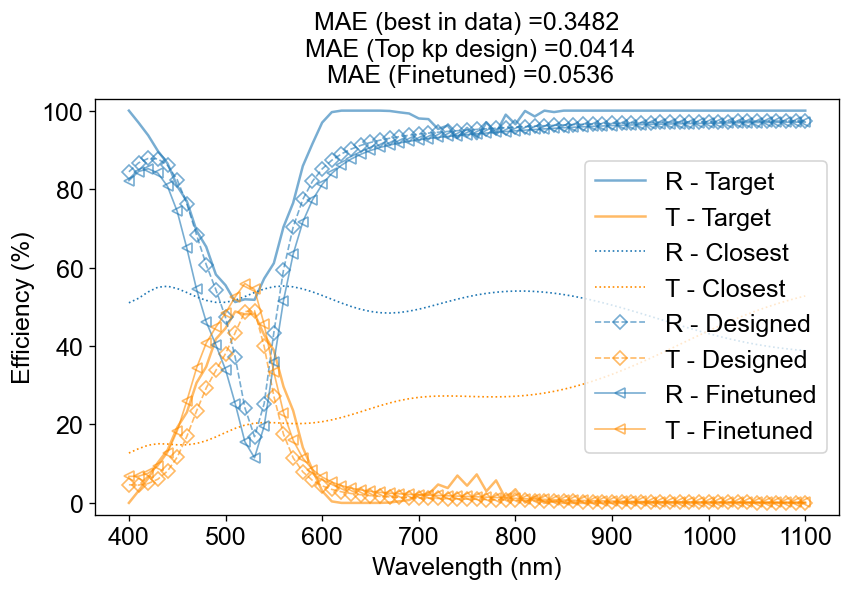

In [134]:
fig = plt.figure(dpi=120, figsize=[8, 4.5])
fig.patch.set_facecolor('white')


plt.plot(wavelengths*1000, np.array(spec_target[:71])*100, color='tab:blue', alpha=0.6,label='R - Target')
plt.plot(wavelengths*1000, np.array(spec_target[ 71:])*100,color='darkorange',alpha=0.6, label='T - Target')


plt.plot(wavelengths*1000, data.train_spec[temp_close, :71]*100, ':', fillstyle = 'none', linewidth = 1, color='tab:blue', label='R - Closest')
plt.plot(wavelengths*1000, data.train_spec[temp_close, 71:]*100, ':', fillstyle = 'none', linewidth = 1, color='darkorange', label='T - Closest')

plt.plot(wavelengths*1000, spec_design_k_p[temp_close_kp, :71]*100, 'D--', fillstyle = 'none', alpha=0.6, color='tab:blue',linewidth = 1,  label='R - Designed')
plt.plot(wavelengths*1000, spec_design_k_p[temp_close_kp, 71:]*100, 'D--', fillstyle = 'none', alpha = 0.6, color='darkorange', linewidth = 1, label='T - Designed')

spec_design_k_p_ft = np.array(spec_design_k_p_ft)

plt.plot(wavelengths*1000, spec_design_k_p_ft[:71]*100, '<-', fillstyle = 'none', alpha=0.6, color='tab:blue',linewidth = 1,  label='R - Finetuned')
plt.plot(wavelengths*1000, spec_design_k_p_ft[71:]*100, '<-', fillstyle = 'none', alpha = 0.6, color='darkorange', linewidth = 1, label='T - Finetuned')


plt.ylim(-3, 103)
plt.legend(loc = 'center right')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Efficiency (%)')
mae_g = round(np.mean(np.abs(np.array(spec_target) - np.array(spec_design_g))), 4)
mae_kp = round(np.mean(np.abs(np.array(spec_target) - spec_design_k_p[temp_close_kp, :])), 4)
mae_kp_ft = round(np.mean(np.abs(np.array(spec_target) - spec_design_k_p_ft)), 4)
mae_d = round(np.mean(np.abs(data.train_spec[temp_close, :] - np.array(spec_target))), 4)
mse_g = round(np.sqrt(np.mean(np.abs(np.array(spec_target) - np.array(spec_design_g)))), 4)
mse_kp = round(np.sqrt(np.mean(np.abs(np.array(spec_target) - spec_design_k_p[temp_close_kp, :]))), 4)
mse_d = round(np.sqrt(np.mean(np.abs(data.train_spec[temp_close, :] - np.array(spec_target)))), 4)

titless = 'MAE (best in data) ='+str(mae_d) +  '\n ' + 'MAE (Top kp design) ='+str(mae_kp) +'\n ' + 'MAE (Finetuned) ='+str(mae_kp_ft) 
print(titless)
# titless = 'RMSE (best in data) ='+str(mse_d) + '\n ' + 'RMSE (Top kp design) ='+str(mse_kp) 
plt.title(titless)



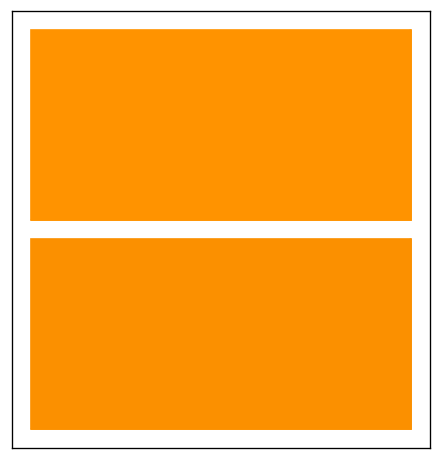

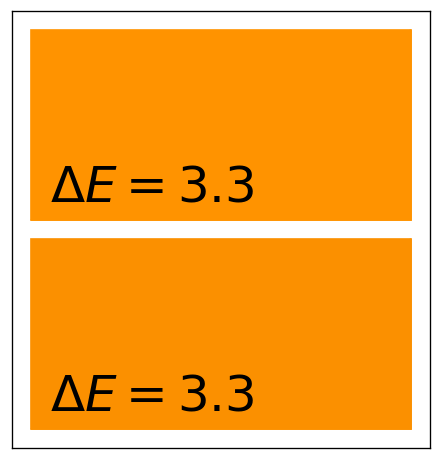

In [191]:
lab_bs, rgb_bs, xyY_bs = get_color(data.train_spec[temp_close]) # for reflective 
lab_bs, rgb_bs, xyY_bs = get_color(data.train_spec[temp_close, 71:]) # for transmissive 

colors_R = []
colors_R.append(colour.plotting.ColourSwatch(RGB=spec_design_k_p_rgb[temp_close_kp]))
colors_R.append(colour.plotting.ColourSwatch(RGB=rgb_ft))

fig, ax = colour.plotting.plot_multi_colour_swatches(colors_R, spacing=0.2, columns=1, width=4, height=2)
fig.patch.set_facecolor('white')
# ax.text( 0.2, 0.2+2.2, r'$\Delta E$'  + '$= {:.1f}$'.format(delta_E_CIE2000(lab2, get_color(spec_design_k_p[temp_close_kp]))[0]),fontsize = 30) # for reflective 
ax.text( 0.2, 0.2+2.2, r'$\Delta E$'  + '$= {:.1f}$'.format(delta_E_CIE2000(lab2, get_color(spec_design_k_p[temp_close_kp][71:]))[0]),fontsize = 30) # for transmissive 
ax.text( 0.2, 0.2, r'$\Delta E$'  + '$= {:.1f}$'.format(delta_E_CIE2000(lab2, lab_ft)), fontsize = 30)

fig


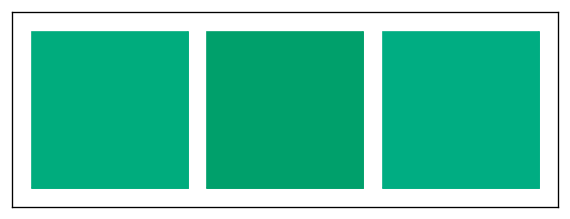

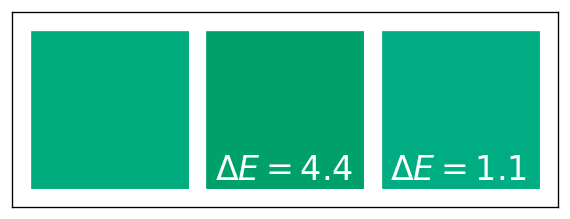

In [135]:

# lab_bs, rgb_bs, xyY_bs = get_color(data.train_spec[temp_close]) # for reflective 
lab_bs, rgb_bs, xyY_bs = get_color(data.train_spec[temp_close, 71:]) # for transmissive 


colors_R = []
# colors_R.append(colour.plotting.ColourSwatch(RGB=rgb_bs))
colors_R.append(colour.plotting.ColourSwatch(RGB=rgb2))
colors_R.append(colour.plotting.ColourSwatch(RGB=spec_design_k_p_rgb[temp_close_kp]))
colors_R.append(colour.plotting.ColourSwatch(RGB=rgb_ft))

fig, ax = colour.plotting.plot_multi_colour_swatches(colors_R, spacing=0.5, columns=7, width=4, height=4)
fig.patch.set_facecolor('white')
# ax.text( 0.2+0, 0.2, r'$\Delta E$'  + '$= {:.1f}$'.format(delta_E_CIE2000(lab2, lab_bs)),fontsize = 20) # for reflective and transmissive
# ax.text( 0.2+4.5, 0.2, r'$\Delta E$'  + '$= {:.1f}$'.format(delta_E_CIE2000(lab2, get_color(spec_design_k_p[temp_close_kp]))[0]),fontsize = 20) # for reflective 

ax.text( 0.2+4.5, 0.2, r'$\Delta E$'  + '$= {:.1f}$'.format(delta_E_CIE2000(lab2, get_color(spec_design_k_p[temp_close_kp][71:]))[0]),color = 'white', fontsize = 20) # for transmissive 

ax.text( 0.2+4.5*2, 0.2, r'$\Delta E$'  + '$= {:.1f}$'.format(delta_E_CIE2000(lab2, lab_ft)), color = 'white', fontsize = 20)

fig



# Visualize the attention 

In [14]:
import altair as alt

In [15]:
def get_spec_mat(mat_thick, dicts = data.struc_word_dict):
    # return the input to transformer model 

    ans = [dicts['BOS']]
    strucss = ['BOS']
    for i in range(len(mat_thick)):
        temp = mat_thick[i]
        strucss.append(temp)
        ans.append(dicts[temp])
    ans.append(dicts['EOS'])
    ans = np.array([ans])
    ans = torch.from_numpy(ans).long()
    strucss.append('EOS')
    return ans, (ans != 0).unsqueeze(-2), strucss


In [16]:

temp_struc_close_kp = ['SiO2_240', 'Ta2O5_90', 'SiO2_130', 'TiO2_80', 'MgF2_140', 'HfO2_80', 'SiO2_130', 'Ta2O5_100', 'SiO2_130', 'Ta2O5_480', 'SiO2_160', 'Ta2O5_490'] # good for attention
mat_temp, thick_temp = return_mat_thick(temp_struc_close_kp)
spec_target = spectrum(mat_temp, thick_temp)


src = torch.tensor([spec_target]).unsqueeze(0).float().to(DEVICE)
src_mask = None

trg, trg_mask, struc_rep = get_spec_mat(temp_struc_close_kp)

model.eval()
with torch.no_grad():
    out = model(src.to(DEVICE), Variable(trg).to(DEVICE), src_mask, trg_mask.to(DEVICE))
    attn = [model.decoder.layers[i].self_attn.attn for i in range(6)]



In [17]:
def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    "convert a dense matrix to a data frame with row and column indices"
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s"
                % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
                "%.3d %s"
                % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        # if float(m[r,c]) != 0 and r < max_row and c < max_col],
        columns=["row", "column", "value", "row_token", "col_token"],
    )


def attn_map(attn, layer, head, row_tokens, col_tokens, max_dim=22):
    df = mtx2df(
        attn[layer][0, head].data,
        max_dim,
        max_dim,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        .properties(height=200, width=200)
        .interactive()
    )

def visualize_layer(attn, layer,n_heads, row_tokens, col_tokens, ntokens=22):
    # ntokens = last_example[0].ntokens

    charts = [
        attn_map(
            attn,
            layer,
            h,
            row_tokens=row_tokens,
            col_tokens=col_tokens,
            max_dim=ntokens,
        )
        for h in range(n_heads)
    ]
    return alt.vconcat(
        charts[0]
        | charts[1]
        # | charts[2]
        | charts[3]
        # | charts[4]
        # | charts[5]
        # | charts[6]
        # | charts[7]
        # layer + 1 due to 0-indexing
    ).properties(title="Block %d" % (layer + 1))




In [18]:
layer_viz = [
    visualize_layer(
        attn, layer, 8, struc_rep, struc_rep, ntokens=22
    )
    for layer in range(6)
]

alt.hconcat(
    layer_viz[0]
    # & layer_viz[1]
    # & layer_viz[2]
    # & layer_viz[3]
    # & layer_viz[4]
    # & layer_viz[5]
    # & layer_viz[6]
    # & layer_viz[7]
    # & layer_viz[8]
    # & layer_viz[9]
    # & layer_viz[10]
    # & layer_viz[11]
)


/home/taigaom/anaconda3/envs/transformer/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.HConcatChart(...)

# Visualization of hidden representation of structure and spectrum

In [27]:
model.eval()

with torch.no_grad():
    
    hidden_index = torch.tensor(data.dev_spec[:1000]).float()
    hidedn_spec = model.fc(hidden_index.to(DEVICE)).to('cpu').data
    hidedn_spec = np.array(hidedn_spec)

a = torch.load('saved_models/optogpt/in_paper/optogpt.pt')

struc_word_dict,  struc_index_dict = a['configs'].struc_word_dict, a['configs'].struc_index_dict

mat_index = {}
for i in range(len(mats[:-1])):
    temp_index = []
    for j in range(50):
        temp_index.append(struc_word_dict[mats[i]+'_'+str(10*j+10)])
    mat_index[mats[i]] = temp_index

In [21]:
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

np.random.seed(2)
min_max_scaler = preprocessing.MinMaxScaler()

all_design = np.concatenate([hidedn_struc, hidedn_spec], axis=0)

all_design_norm = min_max_scaler.fit_transform(all_design)


time_start = time.time()
tsne = TSNE(n_components=2, perplexity=5, n_iter=1500)
tsne_results = tsne.fit_transform(all_design_norm)

# pca_model = PCA(n_components = 2)
# pca_results = pca_model.fit_transform(all_design_norm)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
 

t-SNE done! Time elapsed: 24.48194909095764 seconds


Text(0.5, 1.0, 't-SNE')

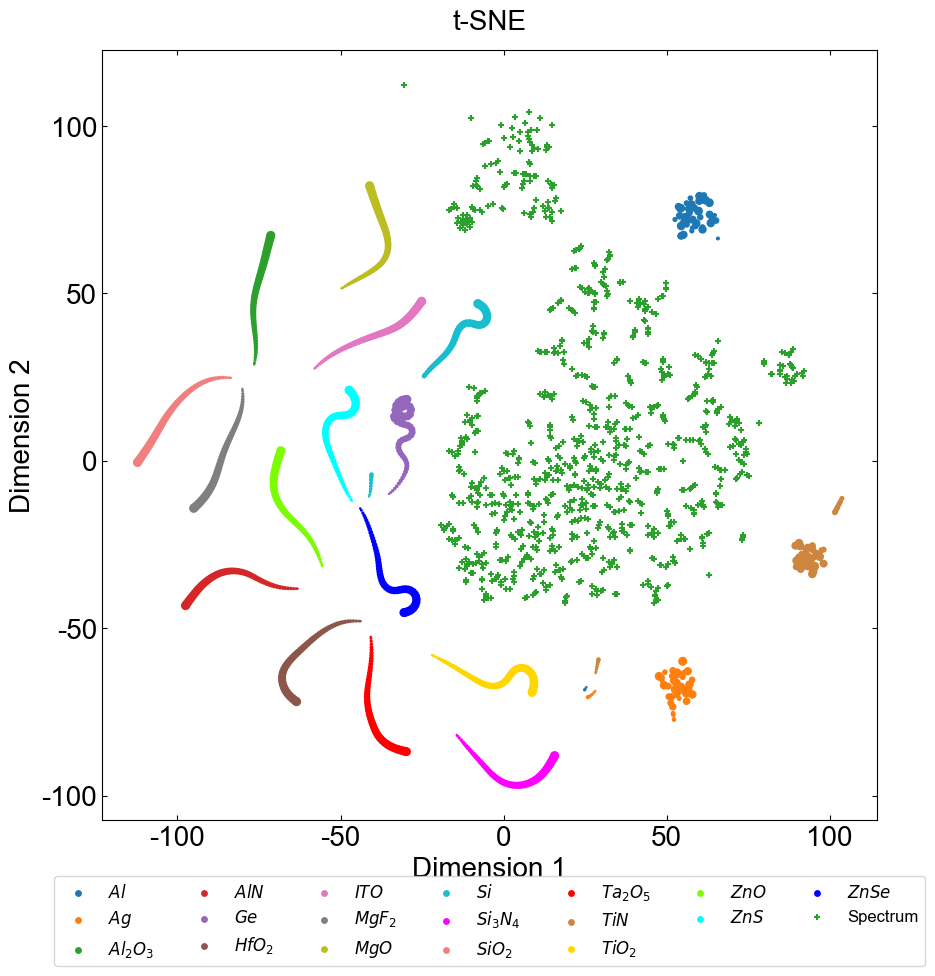

In [26]:
#####################################
import pandas as pd
import seaborn as sns
pd = pd.DataFrame(tsne_results, columns=['PCA 1', 'PCA 2'])


fig = plt.figure(dpi=100, figsize=[10, 10], edgecolor='k')
ax = fig.add_subplot(111)
labels = ['$Al$', '$Ag$', '$Al_2O_3$', '$AlN$', '$Ge$', '$HfO_2$', '$ITO$', '$MgF_2$', '$MgO$', '$Si$', '$Si_3N_4$', '$SiO_2$', '$Ta_2O_5$', '$TiN$', '$TiO_2$', '$ZnO$', '$ZnS$', '$ZnSe$']

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'magenta', 'lightcoral', 'red', 'peru', 'gold', 'lawngreen', 'aqua', 'blue']
for i in range(len(mats[:-1])):
    plt.scatter(tsne_results[mat_index[mats[i]], 0], tsne_results[mat_index[mats[i]], 1], s=30*np.array([(i+1)/50 for i in range(50)]), label=labels[i], color=colors[i], alpha=1)
    
# plt.scatter(tsne_results[904:(904+71), 0], tsne_results[904:(904+71), 0], marker='<',s=30*np.array([(i+1)/71 for i in range(71)]), label='Reflection', alpha=0.5)
# plt.scatter(tsne_results[(904+71):(904+71*2), 0], tsne_results[(904+71):(904+71*2), 1],  marker='<', s=30*np.array([(i+1)/71 for i in range(71)]), label='Transmission', alpha=0.5)
plt.scatter(tsne_results[(904):, 0], tsne_results[(904):, 1],  color='tab:green', marker='+', s=20, label='Spectrum', alpha=1)

# plt.scatter(tsne_results[:4, 0], tsne_results[:4, 1],  color='tab:blue', marker='<', s=100, label='Special', alpha=1) # for the special tokens

# tempp = 815
# plt.scatter(tsne_results[(904+tempp), 0], tsne_results[(904+tempp), 1],  color='tab:red', marker='<', s=30, label='Spectrum', alpha=1)
tempp = 208
# plt.scatter(tsne_results[(904+tempp), 0], tsne_results[(904+tempp), 1],  color='tab:red', marker='<', s=30, label='Spectrum', alpha=1)

ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.xticks([-100, -50, 0, 50, 100],[-100, -50, 0, 50, 100], fontsize=20)
plt.yticks([-100, -50, 0, 50, 100],[-100, -50, 0, 50, 100], fontsize=20)

plt.xlabel('Dimension 1', fontsize=20)
plt.ylabel('Dimension 2', fontsize=20)
plt.legend(fontsize=12, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncols=7)
# plt.title('Dimension Reduction for Hidden Representation \n(t-SNE)',fontsize=12 )
plt.title('t-SNE',fontsize=20, pad = 15)




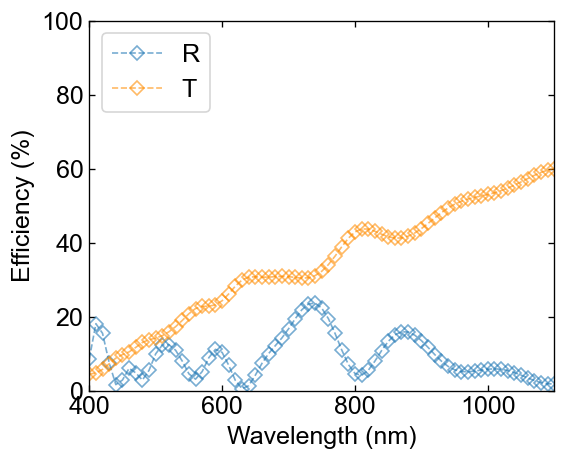

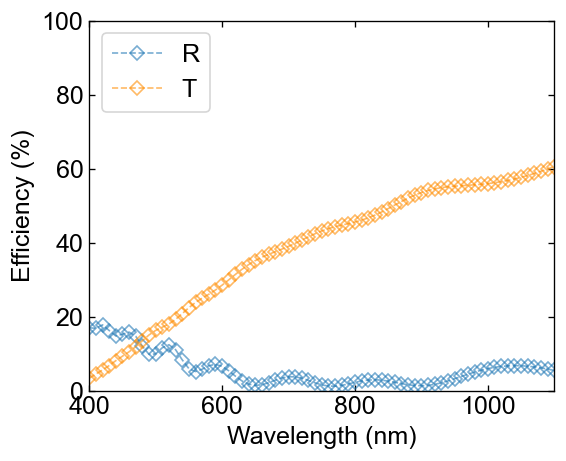

In [152]:

plot_spec = np.array(hidden_index)

tempp1, tempp2 = 815, 208

fig = plt.figure(dpi=120, figsize=[5, 4])
fig.patch.set_facecolor('white')
ax = plt.subplot(111)

plot_spec = np.array(hidden_index)
plt.plot(wavelengths*1000, plot_spec[tempp1, :71]*100, 'D--', fillstyle = 'none', alpha=0.6, color='tab:blue',linewidth = 1,  label='R')
plt.plot(wavelengths*1000, plot_spec[tempp1, 71:]*100, 'D--', fillstyle = 'none', alpha = 0.6, color='darkorange', linewidth = 1, label='T')

plt.ylim(0, 100)
plt.xlim(400, 1100)
plt.legend(loc = 'upper left')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Efficiency (%)')
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')


fig = plt.figure(dpi=120, figsize=[5, 4])
fig.patch.set_facecolor('white')
ax = plt.subplot(111)

plot_spec = np.array(hidden_index)
plt.plot(wavelengths*1000, plot_spec[tempp2, :71]*100, 'D--', fillstyle = 'none', alpha=0.6, color='tab:blue',linewidth = 1,  label='R')
plt.plot(wavelengths*1000, plot_spec[tempp2, 71:]*100, 'D--', fillstyle = 'none', alpha = 0.6, color='darkorange', linewidth = 1, label='T')

plt.ylim(0, 100)
plt.xlim(400, 1100)
plt.legend(loc = 'upper left')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Efficiency (%)')
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')